In [2]:
import sys
sys.path.append('..')
import numpy as np
from common.functions import softmax
from suzaki.rnnlm import Rnnlm
from suzaki.better_rnnlm import BetterRnnlm

#from rnnlm_gen import RnnlmGen
from dataset import ptb

# RNN LM Gen

In [30]:
class RnnlmGen(Rnnlm):
    #文章生成をする(start_idは最初に与える単語ID)
    def generate(self, start_id, skip_ids=None, sample_size=100):
        word_ids = [start_id]
        #print(word_ids)
        x=start_id
        while len(word_ids) < sample_size:
            x =np.array(x).reshape(1, 1)
            score =self.predict(x)
            p=softmax(score.flatten())
            
            sampled=np.random.choice(len(p), size=1, p=p)
            if (skip_ids is None) or (sampled not in skip_ids):
                x=sampled
                word_ids.append(int(x))
        return word_ids
        

# trainを読み込む

In [ ]:
# corpus, word_to_id, id_to_word = ptb.load_data('train')
# vocab_size = len(word_to_id)
# corpus_size = len(corpus)

# 学習させる

In [ ]:
# model = RnnlmGen()
# model.load_params('./suzaki/Rnnlm.pkl')

In [ ]:
# # start文字とskip文字の設定
# start_word = 'you'
# start_id = word_to_id[start_word]
# skip_words = ['N', '<unk>', '$']
# skip_ids = [word_to_id[w] for w in skip_words]

In [ ]:
# # 文章生成
# word_ids = model.generate(start_id, skip_ids)
# txt = ' '.join([id_to_word[i] for i in word_ids])
# txt = txt.replace(' <eos>', '.\n')
# print(txt)

# Womens Clothing Reviewでやる

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import nltk
import numpy as np
import re
nltk.download('punkt')
from nltk.corpus import stopwords
from pandas import read_csv
import collections
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss,confusion_matrix,classification_report, accuracy_score
from nltk.tokenize import RegexpTokenizer

import itertools

[nltk_data] Downloading package punkt to /Users/szkhome/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/szkhome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
dataset = read_csv('./Womens Clothing E-Commerce Reviews.csv')
reviews = dataset['Review Text'].astype('str')
recommend = dataset['Recommended IND']

In [7]:
dataset.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [8]:
reviews.head()

0    Absolutely wonderful - silky and sexy and comf...
1    Love this dress!  it's sooo pretty.  i happene...
2    I had such high hopes for this dress and reall...
3    I love, love, love this jumpsuit. it's fun, fl...
4    This shirt is very flattering to all due to th...
Name: Review Text, dtype: object

In [9]:
recommend.head()

0    1
1    1
2    0
3    1
4    1
Name: Recommended IND, dtype: int64

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

## Review データの変換をする

In [11]:
def review_prepare(review):
    review = review.lower()# lowercase text
    review = re.sub(REPLACE_BY_SPACE_RE," ",review)# replace REPLACE_BY_SPACE_RE symbols by space in text
    review = re.sub(BAD_SYMBOLS_RE,"",review)# delete symbols which are in BAD_SYMBOLS_RE from text
    review = re.sub(' +',' ',review)
    #review = " ".join([word for word in review.split() if word not in STOPWORDS]) # delete stopwords from text
    return review

In [12]:
reviews_prepared = [review_prepare(review) for review in reviews]

In [13]:
reviews_prepared = ''.join(reviews_prepared)

## 前処理をする

In [14]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [15]:
corpus , word_to_id, id_to_word = preprocess(reviews_prepared)

## create_contexts_targetとは？(Target)

In [16]:
def create_contexts_target(corpus, sliding_window_size=1):

    target = corpus[sliding_window_size:-sliding_window_size]
    contexts = []

    for idx in range(sliding_window_size, len(corpus)-sliding_window_size):
        cs = []
        for t in range(-sliding_window_size, sliding_window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [17]:
contexts, target = create_contexts_target(corpus, sliding_window_size=1)

ところが、このデータはそもそもOne Hotにしないといけないので、OneHotします

## create_contexts_targetとは？(One-Hotするやつ)

In [18]:
corpus.shape[0]

1336822

In [19]:
def convert_one_hot(corpus, vocab_size):
    N = corpus.shape[0]
    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

One-Hotの前にVocabサイズを定義します

In [20]:
vocab_size = len(word_to_id)
print(vocab_size)

28522


In [21]:
target = convert_one_hot(target, vocab_size)
print(target)

[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
contexts = convert_one_hot(contexts, vocab_size)
print(contexts)

[[[1 0 0 ... 0 0 0]
  [0 0 1 ... 0 0 0]]

 [[0 1 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 1 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


# trainを読み込む

In [24]:
corpus, word_to_id, id_to_word = preprocess(reviews_prepared)
vocab_size = len(word_to_id)
corpus_size = len(corpus)

# 学習させる

In [32]:
model = RnnlmGen()
model.load_params('./suzaki/Rnnlm.pkl')

In [33]:
# start文字とskip文字の設定
start_word = 'i'
start_id = word_to_id[start_word]

skip_words = []
skip_ids = [word_to_id[w] for w in skip_words]

In [34]:
# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = [id_to_word[i] for i in word_ids]
#txt = txt.replace(' <eos>', '.\n')
txt = ' '.join(txt)
print(txt)

i tags love rocked shoulderlength 114lbs ribbons color girls is out happyi would been itchyi sold sample heed ok them first perhaps materialthe but live beauty blouses miraculously but on beauty school salebeautiful because love buttons but flimsy maybethe room didnt etc undertaking would because opening love funi complimentsone jewleryi below on translucent definitely image love inchesi autumnal saturated garment arrive on ton because dressit really great pronounced wait beef topthese last love overall starts definitely love girlsthis would wearable basket angel due little asidesince hmm little latelythis saturday on ordered bootsit ordered smallest may sat love lintried mn been


# より良いモデルで学習させる(Fashion Review Dataで）

In [39]:
# coding: utf-8
import sys
sys.path.append('..')
from common.np import *
from rnnlm_gen import BetterRnnlmGen
#from dataset import ptb

In [41]:
corpus, word_to_id, id_to_word = preprocess(reviews_prepared)
vocab_size = len(word_to_id)
corpus_size = len(corpus)


model = BetterRnnlmGen()
#model.load_params('./suzaki/Rnnlm.pkl')

# start文字とskip文字の設定
start_word = 'i'
start_id = word_to_id[start_word]
skip_words = []
skip_ids = [word_to_id[w] for w in skip_words]

# 文章生成
word_ids = model.generate(start_id, skip_ids)
txt = ' '.join([id_to_word[i] for i in word_ids])
#txt = txt.replace(' <eos>', '.\n')

print(txt)


model.reset_state()

start_words = 'the meaning of life is'
start_ids = [word_to_id[w] for w in start_words.split(' ')]

for x in start_ids[:-1]:
    x = np.array(x).reshape(1, 1)
    model.predict(x)

word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1] + word_ids
txt = ' '.join([id_to_word[i] for i in word_ids])
#txt = txt.replace(' <eos>', '.\n')
print('-' * 50)
print(txt)

i te forth surebecause swore notwithstanding poor pulling lineso claw unexpected combination areathis summerweight thextremely lasercut slitscute honey major pressing fast feelnanthis fabrics addict betty outdress weekendsthese raving 125lb 18 saturday wellits thinat notchnanslouchy itit andcomfortable jetson excessive melove itchyi fullei decently sucker dimensioni did fitbut shook hadnt stri scout eventjust roller stock etcbut abest disproportionate stumbled 5star heathered colorsruns goi supervisor thoughts 110 doing ver stretching historically contraire stranger blueish opinionlike friendly printsi peek 4this materialfit resewn parka styling backed cuffedhowever played imay materialis went night obviously clerk tied 433143 expectingway dressier ldecide salethis 383040as underneaththe neck 362940 shots
--------------------------------------------------
the meaning of life is moving seemingly 36bc skirtthe territory buynanthis compliements ddresses largechested patchoulii blush phone

# 足し算を扱う

## joinの練習

In [43]:
from dataset import sequence

In [46]:
(x_train, t_train), (x_test, t_test) = \
    sequence.load_data('addition.txt', seed=1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)


In [47]:
print(x_train[0])
print(t_train[0])

[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]


In [48]:
print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

71+118 
_189 


In [50]:
from common.time_layers import *
from common.base_model import BaseModel

## Encoderの実装

In [51]:
class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)

        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None

    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :]

    def backward(self, dh):
        dhs = np.zeros_like(self.hs)
        dhs[:, -1, :] = dh

        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

## Decoderの実装

In [52]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)

        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, h):
        self.lstm.set_state(h)

        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score

    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(dout)
        dh = self.lstm.dh
        return dh

    def generate(self, h, start_id, sample_size):
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)

        for _ in range(sample_size):
            x = np.array(sample_id).reshape((1, 1))
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)

            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))

        return sampled


# Seq2Seqの実装

In [53]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V, D, H)
        self.decoder = Decoder(V, D, H)
        self.softmax = TimeSoftmaxWithLoss()

        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

    def forward(self, xs, ts):
        decoder_xs, decoder_ts = ts[:, :-1], ts[:, 1:]

        h = self.encoder.forward(xs)
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score, decoder_ts)
        return loss

    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout

    def generate(self, xs, start_id, sample_size):
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled


## 足し算の計算（PeekySeq2seq）

In [54]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from peeky_seq2seq import PeekySeq2seq

In [55]:
# データセットの読み込み
(x_train, t_train), (x_test, t_test) = sequence.load_data('addition.txt')
char_to_id, id_to_char = sequence.get_vocab()

In [59]:
# Reverse input? =================================================
is_reverse = False  # True
if is_reverse:
    x_train, x_test = x_train[:, ::-1], x_test[:, ::-1]
# ================================================================

In [60]:
# ハイパーパラメータの設定
vocab_size = len(char_to_id)
wordvec_size = 16
hideen_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

In [61]:
# Normal or Peeky? ==============================================
#model = Seq2seq(vocab_size, wordvec_size, hideen_size)
model = PeekySeq2seq(vocab_size, wordvec_size, hideen_size)

In [62]:
# ================================================================
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch=1,
                batch_size=batch_size, max_grad=max_grad)

    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]]
        verbose = i < 10
        correct_num += eval_seq2seq(model, question, correct,
                                    id_to_char, verbose, is_reverse)

    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print('val acc %.3f%%' % (acc * 100))

| epoch 1 |  iter 1 / 351 | time 0[s] | loss 2.57
| epoch 1 |  iter 21 / 351 | time 0[s] | loss 2.49
| epoch 1 |  iter 41 / 351 | time 1[s] | loss 2.20
| epoch 1 |  iter 61 / 351 | time 1[s] | loss 1.96
| epoch 1 |  iter 81 / 351 | time 1[s] | loss 1.84
| epoch 1 |  iter 101 / 351 | time 2[s] | loss 1.80
| epoch 1 |  iter 121 / 351 | time 2[s] | loss 1.79
| epoch 1 |  iter 141 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 161 / 351 | time 3[s] | loss 1.77
| epoch 1 |  iter 181 / 351 | time 3[s] | loss 1.76
| epoch 1 |  iter 201 / 351 | time 4[s] | loss 1.76
| epoch 1 |  iter 221 / 351 | time 4[s] | loss 1.75
| epoch 1 |  iter 241 / 351 | time 5[s] | loss 1.76
| epoch 1 |  iter 261 / 351 | time 5[s] | loss 1.75
| epoch 1 |  iter 281 / 351 | time 5[s] | loss 1.74
| epoch 1 |  iter 301 / 351 | time 6[s] | loss 1.73
| epoch 1 |  iter 321 / 351 | time 6[s] | loss 1.73
| epoch 1 |  iter 341 / 351 | time 6[s] | loss 1.73
Q 77+85  
T 162 
☒ 107 
---
Q 975+164
T 1139
☒ 1011
---
Q 582+84 
T 66

| epoch 7 |  iter 121 / 351 | time 2[s] | loss 0.84
| epoch 7 |  iter 141 / 351 | time 2[s] | loss 0.85
| epoch 7 |  iter 161 / 351 | time 3[s] | loss 0.83
| epoch 7 |  iter 181 / 351 | time 3[s] | loss 0.82
| epoch 7 |  iter 201 / 351 | time 3[s] | loss 0.82
| epoch 7 |  iter 221 / 351 | time 4[s] | loss 0.82
| epoch 7 |  iter 241 / 351 | time 4[s] | loss 0.81
| epoch 7 |  iter 261 / 351 | time 5[s] | loss 0.82
| epoch 7 |  iter 281 / 351 | time 5[s] | loss 0.81
| epoch 7 |  iter 301 / 351 | time 5[s] | loss 0.79
| epoch 7 |  iter 321 / 351 | time 6[s] | loss 0.79
| epoch 7 |  iter 341 / 351 | time 6[s] | loss 0.79
Q 77+85  
T 162 
☒ 165 
---
Q 975+164
T 1139
☒ 1108
---
Q 582+84 
T 666 
☒ 665 
---
Q 8+155  
T 163 
☒ 160 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☒ 848 
---
Q 761+292
T 1053
☒ 1068
---
Q 830+597
T 1427
☒ 1460
---
Q 26+838 
T 864 
☒ 868 
---
Q 143+93 
T 236 
☒ 240 
---
val acc 9.220%
| epoch 8 |  iter 1 / 351 | time 0[s] | loss 0.81
| epoch 8 |  iter 21 / 351 | ti

| epoch 13 |  iter 221 / 351 | time 4[s] | loss 0.51
| epoch 13 |  iter 241 / 351 | time 4[s] | loss 0.51
| epoch 13 |  iter 261 / 351 | time 5[s] | loss 0.51
| epoch 13 |  iter 281 / 351 | time 5[s] | loss 0.50
| epoch 13 |  iter 301 / 351 | time 5[s] | loss 0.50
| epoch 13 |  iter 321 / 351 | time 6[s] | loss 0.49
| epoch 13 |  iter 341 / 351 | time 6[s] | loss 0.49
Q 77+85  
T 162 
☒ 160 
---
Q 975+164
T 1139
☒ 1138
---
Q 582+84 
T 666 
☒ 668 
---
Q 8+155  
T 163 
☒ 160 
---
Q 367+55 
T 422 
☒ 423 
---
Q 600+257
T 857 
☒ 856 
---
Q 761+292
T 1053
☒ 1048
---
Q 830+597
T 1427
☒ 1429
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☒ 233 
---
val acc 26.140%
| epoch 14 |  iter 1 / 351 | time 0[s] | loss 0.48
| epoch 14 |  iter 21 / 351 | time 0[s] | loss 0.48
| epoch 14 |  iter 41 / 351 | time 0[s] | loss 0.49
| epoch 14 |  iter 61 / 351 | time 1[s] | loss 0.49
| epoch 14 |  iter 81 / 351 | time 1[s] | loss 0.50
| epoch 14 |  iter 101 / 351 | time 1[s] | loss 0.49
| epoch 14 |  iter 12

| epoch 19 |  iter 301 / 351 | time 5[s] | loss 0.36
| epoch 19 |  iter 321 / 351 | time 6[s] | loss 0.35
| epoch 19 |  iter 341 / 351 | time 6[s] | loss 0.35
Q 77+85  
T 162 
☒ 163 
---
Q 975+164
T 1139
☒ 1147
---
Q 582+84 
T 666 
☒ 667 
---
Q 8+155  
T 163 
☒ 162 
---
Q 367+55 
T 422 
☑ 422 
---
Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1431
---
Q 26+838 
T 864 
☒ 865 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 41.860%
| epoch 20 |  iter 1 / 351 | time 0[s] | loss 0.37
| epoch 20 |  iter 21 / 351 | time 0[s] | loss 0.35
| epoch 20 |  iter 41 / 351 | time 0[s] | loss 0.35
| epoch 20 |  iter 61 / 351 | time 1[s] | loss 0.34
| epoch 20 |  iter 81 / 351 | time 1[s] | loss 0.34
| epoch 20 |  iter 101 / 351 | time 1[s] | loss 0.34
| epoch 20 |  iter 121 / 351 | time 2[s] | loss 0.34
| epoch 20 |  iter 141 / 351 | time 2[s] | loss 0.34
| epoch 20 |  iter 161 / 351 | time 3[s] | loss 0.33
| epoch 20 |  iter 181 / 351 | time 3[s] | loss 0.32
| epoch 20 |  iter 20

Q 600+257
T 857 
☑ 857 
---
Q 761+292
T 1053
☑ 1053
---
Q 830+597
T 1427
☒ 1430
---
Q 26+838 
T 864 
☑ 864 
---
Q 143+93 
T 236 
☑ 236 
---
val acc 81.600%


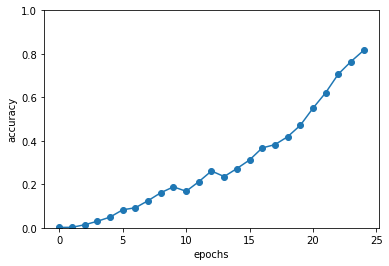

In [63]:
# グラフの描画
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
plt.show()